In [44]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
from jupyterthemes import jtplot
jtplot.style()

%matplotlib inline
np.random.seed(45)
tf.random.set_seed(45)

For this chapter I'll take a different approach. Mostly read the book and type relevant code snippets in the notebook. Hopefully will be much faster.

## Forecasting a time series

Let's define a function to generate a time series

In [25]:


BATCH_SIZE = 3

def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  # wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20))  # wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) -0.5)  # add a bit of noise
    return series[..., np.newaxis].astype(np.float32)

series = generate_time_series(BATCH_SIZE, 50)

A sample of how they look. In these examples we're tipically interested in predicting the next value in the time series (marked with the green x)

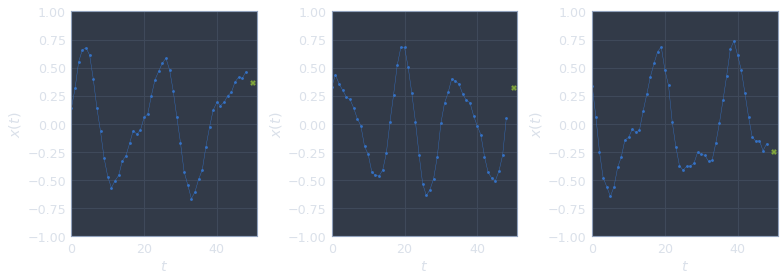

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=BATCH_SIZE, figsize=(11,4))

for idx, ax in enumerate(axes):
    ts = series[idx]
    x_axis = range(len(ts[:-1]))
    ax.plot(x_axis, ts[:-1], linewidth=0.4, marker='.')
    ax.plot(len(ts[:-1])+1, ts[-1], marker='X')
    
    ax.set_ylabel('$x(t)$')
    ax.set_xlabel('$t$')
    ax.set_xlim(left=0, right=len(ts) + 1)
    ax.set_ylim(bottom=-1, top=1)

    fig.tight_layout()

Let's create some datasets!

In [39]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

### Baseline Metrics

The simplest appreach we can take for prediction, is simply to predict the last value just seen. Let's use that and calculate the mean squared error

In [56]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02101442

Another approach we can take is to create a simple fully connected network to create a linar regression model. Each prediction will be a linear combination of the values in the time series

In [76]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50,1]),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1432 - val_loss: 0.0702
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0519 - val_loss: 0.0378
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0292 - val_loss: 0.0223
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0178 - val_loss: 0.0144
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0124 - val_loss: 0.0107
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0098 - val_loss: 0.0088
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0085 - val_loss: 0.0076
Epoch 8/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0076 - val_loss: 0.0069
Epoch 9/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0069 - val_loss: 0.0062
Epoch 10/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0063 - val_loss: 0.0058

In [77]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [78]:
model.history.history['val_loss'][-1]

0.003952295519411564

Much better loss!

### Implementing a SimpleRNN

Time series are tipycally represented as 3D arrays of shape [batch_size, time_steps, dimensionality], where dimensinality is 1 for univariate time series. Keras' SimpleRNN uses tanh as the default activation for these layers

In [79]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1]) 
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 2s 7ms/step - loss: 0.1386 - val_loss: 0.1406
Epoch 2/20
219/219 [==============================] - 1s 7ms/step - loss: 0.1382 - val_loss: 0.1384
Epoch 3/20
219/219 [==============================] - 1s 7ms/step - loss: 0.1389 - val_loss: 0.1382
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1386 - val_loss: 0.1388
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1384 - val_loss: 0.1446
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1386 - val_loss: 0.1381
Epoch 7/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1387 - val_loss: 0.1443
Epoch 8/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1384 - val_loss: 0.1389
Epoch 9/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1380 - val_loss: 0.1384
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.1383 - val_loss: 0.1392

<bound method Network.summary of <tensorflow.python.keras.engine.sequential.Sequential object at 0x7ff7783d4580>>

In [81]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_2 (SimpleRNN)     (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [80]:
model.history.history['val_loss'][-1]

0.13818350434303284

**Note on Trend and Seasonality**

Other time series models such as ARIMA require you to detrend and remove seasonality from your data prior to fitting. When using RNNs it is usually not necessary to do this but it may improve performance in some cases as the model will not have to learn the trend or the seasonality

### Deep RNNs

We can stack SimpleRNNS to create deeper models. Note we use ```return_sequences=True``` so that each intermediate layer returns a 3D array conrainig outputs for all time steps

In [84]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 5s 23ms/step - loss: 0.0122 - val_loss: 0.0040
Epoch 2/5
219/219 [==============================] - 5s 22ms/step - loss: 0.0039 - val_loss: 0.0033
Epoch 3/5
219/219 [==============================] - 5s 22ms/step - loss: 0.0037 - val_loss: 0.0031
Epoch 4/5
219/219 [==============================] - 5s 21ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/5
219/219 [==============================] - 5s 21ms/step - loss: 0.0032 - val_loss: 0.0030


The last layer is a bit inneficient since it's just a single RNN unit. We could replace it with a Dense layer which would allow us to use any activation, with the model performing just as well.

In [85]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 4s 17ms/step - loss: 0.0326 - val_loss: 0.0054
Epoch 2/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0047 - val_loss: 0.0037
Epoch 3/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0038 - val_loss: 0.0033
Epoch 4/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0034 - val_loss: 0.0031
Epoch 5/5
219/219 [==============================] - 4s 16ms/step - loss: 0.0033 - val_loss: 0.0031


### Forecasting Several Time Steps Ahead

If we want to predict the next 10 values in the time series, one approach we can take is to predict the next value, add that to the inputs, then predict the next one, add that to inputs and so on. The downside with this approach is that prediction for later steps will be less accurate (errors might accumulate)

In [93]:
series = generate_time_series(1, n_steps + 10)
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]
X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)
Y_pred = X[:, n_steps:]

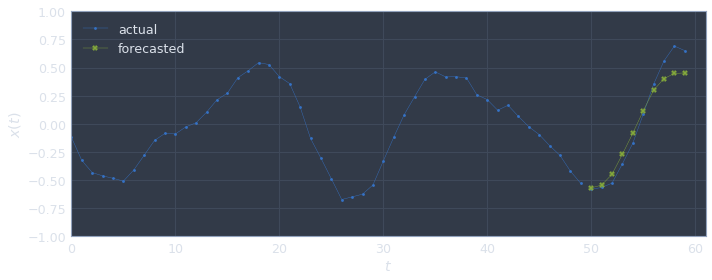

In [121]:
fig, ax = plt.subplots(figsize=(10,4))

t = range(n_steps)
ax.plot(t, X_new[0, :, 0], linewidth=0.4, marker='.')

actual_vals = series[0, n_steps:, 0]
ax.plot(range(n_steps, 60), actual_vals, linewidth=0.4, marker='.', c='b', label='actual')

ax.plot(range(n_steps, 60), Y_pred[0, :, 0], linewidth=0.4, marker='X', c='g', label='forecasted')

ax.set_ylabel('$x(t)$')
ax.set_xlabel('$t$')
ax.set_xlim(left=0, right=n_steps + 10 + 1)
ax.set_ylim(bottom=-1, top=1)
ax.legend()

fig.tight_layout()

An alternative is to train an RNN to predict all 10 next values at once. This requires us to change the target vectors to contain the next 10 values

In [122]:
series = generate_time_series(10000, n_steps+10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

And change the outputs to have 10 units instead of 1

In [123]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=5, validation_data=(X_valid, y_valid))

Epoch 1/5
219/219 [==============================] - 4s 17ms/step - loss: 0.1589 - val_loss: 0.1460
Epoch 2/5
219/219 [==============================] - 4s 16ms/step - loss: 0.1440 - val_loss: 0.1451
Epoch 3/5
219/219 [==============================] - 4s 16ms/step - loss: 0.1435 - val_loss: 0.1450
Epoch 4/5
219/219 [==============================] - 4s 16ms/step - loss: 0.1432 - val_loss: 0.1444
Epoch 5/5
219/219 [==============================] - 4s 16ms/step - loss: 0.1430 - val_loss: 0.1447


In [127]:
Y_pred = model.predict(X_new)

0.24585176

Let's convert this model to a sequence-to-sequence model. Book pg 510 for description

In [128]:
Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [130]:
Y_train.shape

(7000, 50, 10)

Now we  add ```return_sequences``` to all layers and introduce a ```TimeDistributed``` layer. It wraps any layer and applies it at each step of a time sequence.

We will also use a custom metric to compute the MSE over the output at the last time step

In [136]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])
    
model.compile(optimizer=keras.optimizers.Adam(lr=0.01),
              loss='mean_squared_error', metrics=[last_time_step_mse])
model.fit(X_train, Y_train, epochs=20, validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 4s 18ms/step - loss: 0.0478 - last_time_step_mse: 0.0364 - val_loss: 0.0389 - val_last_time_step_mse: 0.0256
Epoch 2/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0353 - last_time_step_mse: 0.0226 - val_loss: 0.0336 - val_last_time_step_mse: 0.0206
Epoch 3/20
219/219 [==============================] - 5s 22ms/step - loss: 0.0315 - last_time_step_mse: 0.0188 - val_loss: 0.0334 - val_last_time_step_mse: 0.0217
Epoch 4/20
219/219 [==============================] - 4s 20ms/step - loss: 0.0290 - last_time_step_mse: 0.0164 - val_loss: 0.0263 - val_last_time_step_mse: 0.0127
Epoch 5/20
219/219 [==============================] - 7s 31ms/step - loss: 0.0272 - last_time_step_mse: 0.0147 - val_loss: 0.0261 - val_last_time_step_mse: 0.0133
Epoch 6/20
219/219 [==============================] - 5s 23ms/step - loss: 0.0257 - last_time_step_mse: 0.0129 - val_loss: 0.0235 - val_last_time_step_mse: 0.0104
Epoch 7/20
219/219 [==

Tip: When forecasting time series, it is often useful to have some error bars along with your predictions. For this, an efficient technique is MC Dropout: add an MC Dropout layer within each memory cell, dropping part of the inputs and hidden states. After training, to forecast a new time series, use the model many times and compute the mean and standard deviation of the predictions at each time step.

## Handling Long Sequences